# EDA – Estatística Inferencial & Feature Engineering Inicial

<a href="../README.md" title="Voltar para a página principal">
🏠 Voltar para Home
</a>

## Visão Geral

A **Estatística Inferencial** tem como objetivo **investigar relações, padrões e diferenças estatisticamente significativas** dentro do dataset.
Enquanto a Estatística Descritiva respondeu *“o que aconteceu?”*, agora buscamos responder *“por que aconteceu?”* — isto é, compreender **associações, dependências e fatores que influenciam diretamente o comportamento do TARGET (OTIF / atraso)**.

Nesta etapa, aprofundamos a análise utilizando ferramentas que permitem:

- avaliar correlações lineares e não lineares entre variáveis numéricas (*Pearson* e *Spearman*);
- comparar grupos e testar diferenças significativas (*ANOVA*);
- verificar dependência entre variáveis categóricas (*qui-quadrado*);
- explorar a **separabilidade** entre pedidos no prazo e pedidos atrasados;
- identificar variáveis-chave que servem como **candidatas fortes para Feature Engineering**.

A Inferência Estatística opera como um elo entre a EDA descritiva e a fase de modelagem, fornecendo evidências quantitativas sobre **quais variáveis realmente importam**, quais são redundantes e onde existe potencial para criação de novas features.

### Tópicos abordados nesta etapa

- correlação entre variáveis numéricas
- análise de dependência entre categorias
- testes estatísticos para diferenças entre grupos
- investigação da força e direção das relações
- primeiros insights para criação de novas features (FE inicial)

Essas análises compõem a fundação que guiará a etapa seguinte — **Preparação Avançada dos Dados & Feature Engineering Completo** — além de orientar quais modelos tendem a performar melhor na predição de atraso (OTIF).

# Importações

In [58]:
# Estatisticas e DataFrames
import pandas as pd
import numpy as np

# Gráficos
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import stats,f_oneway,chi2_contingency

# Trabalho com html
from IPython.display import display, HTML

# 1. Carregamento e Visualização Preliminar

***Descrição:*** Utilizando o dataset de acompanhamento operacional dos pedidos tratados.
> **Arquivo e:** database/processed/acompanhamento_operacional_clean.csv

In [38]:
file_path = "../database/processed/acompanhamento_operacional_clean.csv"

df_main = pd.read_csv(file_path)

cols_remov = ['ss','fase','fl_atraso_zt','fl_sem_minuta','motivo_atraso','status','analise_transporte']

df_main = df_main.drop(columns=cols_remov)

df_main.columns

Index(['sigla_cliente', 'tipo_veiculo', 'qtde_itens', 'volume', 'peso', 'm3',
       'uf', 'fl_base', 'representante', 'flag_entrega_agendada', 'modalidade',
       'fl_atraso_cli', 'qtde_ocams', 'peso_cubado_rodoviario',
       'horas_pre_conferencia', 'horas_distribuicao_cotas',
       'horas_planejamento', 'horas_divisao_ocam', 'horas_coleta',
       'horas_conferencia', 'horas_emissao', 'horas_analise_producao',
       'horas_minuta', 'horas_exped_minuta', 'hora_analise_transporte'],
      dtype='object')

**Nota Técnica:** As colunas `ss`,`fase`,`fl_atraso_zt`,`fl_sem_minuta`,`motivo_atraso`,`status`,`analise_transporte` foram removidas devido ao risco de leakage, ou seja, vazamento de dados na etapa de modelagem.

In [39]:
# Definindo o TARGET
TARGET = "fl_atraso_cli"

# Separa numéricas e categóricas
cols_num = df_main.select_dtypes(include=["int64", "float64"]).columns.tolist()
cols_cat = df_main.select_dtypes(include=["object"]).columns.tolist()

# Remove o TARGET da lista numérica, caso esteja lá
if TARGET in cols_num:
    cols_num.remove(TARGET)

# Cria o DataFrame-resumo
df_summary = pd.DataFrame({
    'tipo': ['numerico', 'categorico'],
    'qtde': [len(cols_num), len(cols_cat)],
    'features': [cols_num, cols_cat]
})

html = f"""
<div style="display: flex; gap: 50px; justify-content: left;">

    <div>
        <h3 style="text-align:center;">Summary</h3>
        {df_summary.to_html(index=True)}
    </div>

</div>
"""

display(HTML(html))

,tipo,qtde,features
0,numerico,18,"[qtde_itens, volume, peso, m3, fl_base, qtde_ocams, peso_cubado_rodoviario, horas_pre_conferencia, horas_distribuicao_cotas, horas_planejamento, horas_divisao_ocam, horas_coleta, horas_conferencia, horas_emissao, horas_analise_producao, horas_minuta, horas_exped_minuta, hora_analise_transporte]"
1,categorico,6,"[sigla_cliente, tipo_veiculo, uf, representante, flag_entrega_agendada, modalidade]"


# 2. Correlação (Pearson & Spearman)

***Descrição:***
A análise de correlação tem como objetivo identificar **relações estatísticas** entre variáveis numéricas, permitindo compreender **quais etapas operacionais se movem juntas**, quais são independentes e quais apresentam comportamento semelhante aos *padrões de atraso (TARGET)*.

A correlação é uma das etapas mais importantes da Estatística Inferencial, pois ajuda a responder:

- Quais variáveis numéricas mais influenciam o atraso (OTIF)?
- Existem etapas que aumentam simultaneamente (ex.: horas_minuta + horas_emissão)?
- A relação é linear ou apenas monotônica?
- Existem variáveis redundantes que carregam a mesma informação?

Enquanto a análise descritiva mostrou **o que está acontecendo**, a análise de correlação começa a revelar **por que está acontecendo**.

---

## **Tipos de Correlação Utilizados**

### **1. Correlação de Pearson (`corr = pearson`)**

- Mede **correlação linear** entre duas variáveis.
- É sensível a outliers.
- Ideal quando as distribuições estão próximas de normais **ou** quando queremos avaliar diretamente tendências lineares.

**Interpretação típica:**

- `0.0 a 0.2` → relação fraca
- `0.2 a 0.4` → relação moderada
- `0.4+` → relação forte (em contexto operacional já é bem relevante)

---

### **2. Correlação de Spearman (`corr = spearman`)**

- Mede **correlação por postos** (monotônica), não depende de linearidade.
- Robusta a outliers.
- Ótima para distribuições assimétricas ou com caudas longas — exatamente o caso do dataset OTIF.

**Interpretação típica:**

- Se Spearman alto e Pearson baixo → relação existe, mas **não é linear**.
- Se ambos são altos → relação forte e consistente.

---

### **Objetivo desta Seção**

Nesta seção, buscamos:

- Calcular correlação de Pearson e Spearman para todas as variáveis numéricas.
- Identificar colunas mais próximas do TARGET.
- Investigar redundância ou dependência entre etapas.
- Basear decisões futuras de:

  - Feature Engineering
  - Remoção de variáveis redundantes
  - Seleção de variáveis para modelagem
  - Análises para apresentação ao board

In [40]:
# Subconjunto numérico
df_num = df_main[cols_num + [TARGET]].copy()

# Correlações entre variáveis numéricas (Pearson e Spearman)
corr_pearson  = df_num.corr(method="pearson")
corr_spearman = df_num.corr(method="spearman")

# Exibir correlação com o TARGET (ordenado)
corr_target_pearson = (
    corr_pearson[TARGET]
    .drop(TARGET)
    .sort_values(ascending=False)
)

corr_target_spearman = (
    corr_spearman[TARGET]
    .drop(TARGET)
    .sort_values(ascending=False)
)

# display(corr_target_pearson.to_frame("corr_pearson_com_target"))
# display(corr_target_spearman.to_frame("corr_spearman_com_target"))

html = f"""
<div style="display: flex; gap: 50px; justify-content: left;">

    <div>
        <h3 style="text-align:center;">Correlação de Pearson</h3>
        {corr_target_pearson.to_frame().to_html(index=True)}
    </div>

    <div>
        <h3 style="text-align:center;">Correlação de Spearman</h3>
        {corr_target_spearman.to_frame().to_html(index=True)}
    </div>
</div>
"""

display(HTML(html))


,fl_atraso_cli
horas_divisao_ocam,0.108179
horas_planejamento,0.101041
horas_conferencia,0.085123
horas_coleta,0.082303
fl_base,0.060924
qtde_itens,0.059147
horas_exped_minuta,0.049964
horas_analise_producao,0.048727
m3,0.047702
peso,0.034523


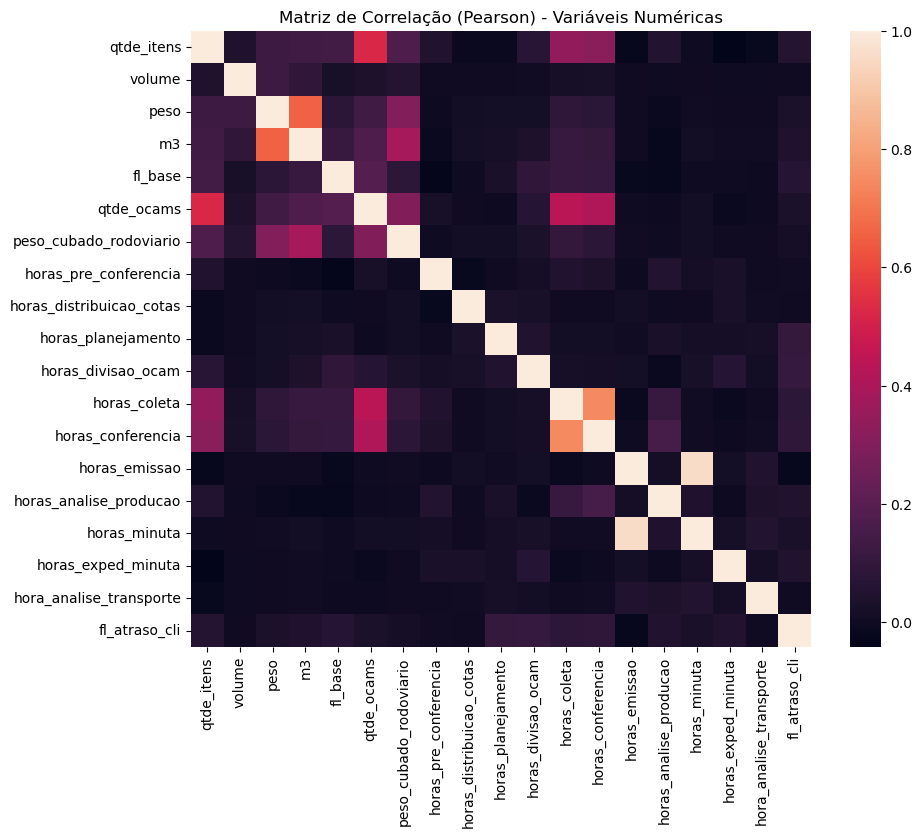

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=False)
plt.title("Matriz de Correlação (Pearson) - Variáveis Numéricas")
plt.show()

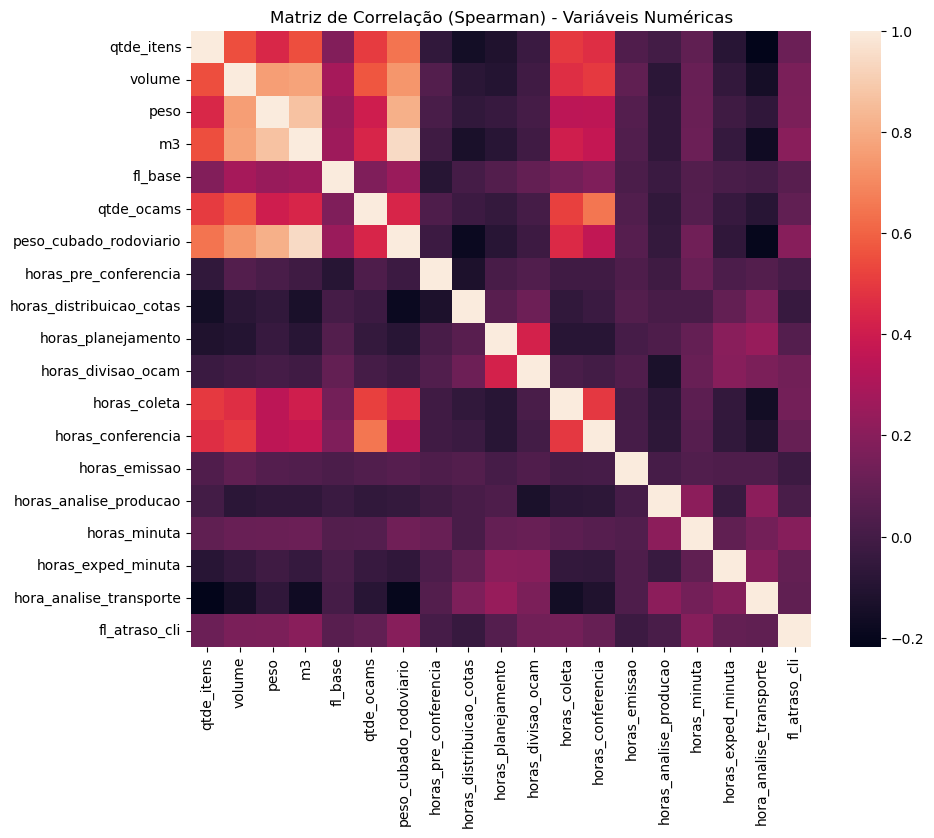

In [52]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_spearman, annot=False)
plt.title("Matriz de Correlação (Spearman) - Variáveis Numéricas")
plt.show()

**Nota Técnica:**  A análise revelou que **nenhuma variável isoladamente possui correlação forte com o atraso**.
Isso é esperado, pois a **OTIF é um fenômeno multifatorial e com isso não é causado por um único fator, mas por combinações de eventos distribuídos ao longo do processo logístico.

Ainda assim, a correlação identificou **tendências relevantes** que ajudam a explicar o comportamento operacional.

---

### **2. Correlação de Pearson (linear)**

As maiores correlações lineares com atraso foram:

| Variável               | Correlação | Interpretação                                     |
| ---------------------- | ---------- | ------------------------------------------------- |
| **horas_divisao_ocam** | 0.108      | pedidos com muitas divisões tendem a atrasar      |
| **horas_planejamento** | 0.101      | planejamento acima do normal impacta o downstream |
| **horas_conferencia**  | 0.085      | conferências mais longas elevam risco de atraso   |
| **horas_coleta**       | 0.082      | dificuldade na coleta afeta fluxo                 |
| **qtde_itens**         | 0.059      | pedidos maiores tendem a ser mais lentos          |

**Interpretação:** Pearson mostrou apenas **associações fracas**, reforçando que o atraso não depende de uma relação linear direta com nenhuma variável.

---

### **3. Correlação de Spearman (monotônica)**

Aqui surgiram padrões muito mais expressivos:

| Variável                   | Spearman | Interpretação                                    |
| -------------------------- | -------- | ------------------------------------------------ |
| **m3**                     | 0.202    | cargas volumosas elevam o risco de atraso        |
| **peso_cubado_rodoviario** | 0.196    | cubagem alta = gargalo operacional               |
| **horas_minuta**           | 0.194    | minutas longas → impacto no prazo                |
| **peso**                   | 0.167    | pedidos muito pesados = operação mais lenta      |
| **volume**                 | 0.158    | confirma padrão relacionado ao tamanho do pedido |

**Interpretação:** Spearman capturou um padrão monotônico claro, **quanto maior e mais complexa a carga, maior o risco de atraso.**

Mesmo sem linearidade, existe clara relação de ordem entre tamanho/complexidade da carga e atraso.

---

### **4. Interpretação Operacional Integrada**

Os resultados de Pearson e Spearman, combinados, reforçam a visão:

- Pedidos **grandes**, **pesados**, **volumosos** e **fragmentados em muitas OCAMs**
  → exigem mais coleta, mais movimentação, mais conferências, mais tempo de minuta
  → **aumentam o risco de atraso**.

Os indicadores de tempo das etapas do fluxo (coleta, conferência, minuta, análise) também apresentam correlação modesta, mas consistente com o comportamento real da operação.

# **3. ANOVA – Comparando Grupos (Atraso vs Não Atraso)**

### *Objetivo deste bloco*

A ANOVA (Analysis of Variance) é um teste estatístico utilizado para verificar se **a média de uma variável numérica** é significativamente diferente entre dois ou mais grupos.

No nosso caso, queremos comparar:

* **Grupo 0** → pedidos *sem atraso*
* **Grupo 1** → pedidos *com atraso*

e verificar para cada feature numérica se **a média dessa feature muda significativamente quando há atraso** ou caso a variável mude, essa variável tem potencial explicativo para a modelagem.

---

### **Interpretação dos Resultados**

- **p-value < 0.05**
 → diferença significativa entre os grupos
 → a variável ajuda a explicar o atraso
 → vale manter para modelagem
- **p-value ≥ 0.05**
  → diferenças não significativas
  → variável provavelmente não distingue bem os grupos
  → ainda pode ser útil, mas não é um forte discriminador individual

- **f-statistic = 1**
→ grupos iguais, não existe diferença
- **f-statistic > 1**
→ diferenças significativas
- **f-statistic >> 1**
→ diferenças altamente significativas e muito forte

In [55]:
result_anova = []

for col in cols_num:
    grupo_sem_atraso = df_main.loc[df_main[TARGET] == 0, col].dropna()
    grupo_com_atraso = df_main.loc[df_main[TARGET] == 1, col].dropna()
    
    # Só roda se os dois grupos tiverem dados
    if len(grupo_sem_atraso) > 10 and len(grupo_com_atraso) > 10:
        F, p = stats.f_oneway(grupo_sem_atraso, grupo_com_atraso)
        result_anova.append({
            "feature": col,
            "f_statistic": F,
            "p_value": p
        })

df_anova = (
    pd.DataFrame(result_anova)
      .sort_values("p_value")
      .reset_index(drop=True)
)

# Adiciona coluna se é estatisticamente significativo
df_anova["significativo_5pct"] = df_anova["p_value"] < 0.05

html = f"""
<div style="display: flex; gap: 50px; justify-content: left;">

    <div>
        <h3 style="text-align:center;">ANOVA</h3>
        {df_anova.to_html(index=False)}
    </div>

</div>
"""

display(HTML(html))

/tmp/ipykernel_38188/1568776410.py:9: DeprecationWarning: Please import `f_oneway` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  F, p = stats.f_oneway(grupo_sem_atraso, grupo_com_atraso)


feature,f_statistic,p_value,significativo_5pct
qtde_itens,1714.602583,0.000000e+00,True
fl_base,1819.566140,0.000000e+00,True
horas_divisao_ocam,5783.234460,0.000000e+00,True
horas_planejamento,5037.615296,0.000000e+00,True
horas_conferencia,3564.702534,0.000000e+00,True
horas_coleta,3330.829576,0.000000e+00,True
horas_exped_minuta,1222.285906,1.879743e-267,True
horas_analise_producao,1162.383648,1.823463e-254,True
m3,1113.866668,6.038817e-244,True
peso,582.790162,1.103748e-128,True


**Nota Técnica:** A análise ANOVA comparou as médias das variáveis numéricas entre:

* **Grupo 0** → pedidos sem atraso
* **Grupo 1** → pedidos com atraso

O resultado foi extremamente consistente, pois as principais variáveis operacionais apresentaram **p-value = 0**, indicando rejeição clara da hipótese nula com valores f-statistica muito acima de 1 o que reforça a rejeição da hipotese nula, ou seja, **as médias dessas variáveis são estatisticamente diferentes entre pedidos pontuais e pedidos atrasados.**

As variáveis com maior força discriminativa foram:

| Feature            | F-statistic |
| ------------------ | ----------- |
| horas_divisao_ocam | **5783**    |
| horas_planejamento | **5037**    |
| horas_conferencia  | **3564**    |
| horas_coleta       | **3330**    |
| qtde_itens         | **1714**    |
| fl_base            | **1819**    |

Esses valores de F são extremamente elevados, indicando que a variabilidade **entre os grupos** (atrasados vs não atrasados) é MUITO maior do que a variabilidade **dentro dos grupos**. Isso significa que essas variáveis **mudam de forma sistemática quando há atraso**, são excelentes candidatas para modelagem preditiva e capturam padrões reais da operação que explicam o OTIF.

Por outro lado, algumas variáveis apresentaram p-value elevado e F baixo (como volume, horas_distribuicao_cotas, hora_analise_transporte), indicando que **não diferenciam** atrasados vs não atrasados.

Assim, a ANOVA reforça que **o atraso está fortemente associado à complexidade do pedido e ao tempo consumido nas etapas internas com maior absorção operacional.**

# 4. Teste Qui-Quadrado – Dependência entre Categorias e Atraso

### ***Descrição Geral***

O teste **Qui-Quadrado de Independência** é utilizado para verificar se existe **associação estatística entre duas variáveis categóricas**, no contexto OTIF, ele responde diretamente à pergunta se **certas categorias (como cliente, UF, tipo de veículo, representações, modalidade etc.) aumentam a probabilidade de atraso**

O teste compara as **frequências observadas** com as **frequências esperadas** sob hipótese de independência.
Se os valores observados se afastam muito do esperado e se há evidência de dependência.

---

### 📌 **Objetivo nesta Análise**

Avaliar se as categorias do dataset possuem relação significativa com a variável-alvo `fl_atraso_cli`.

- **Grupo 0** → pedidos entregues dentro do prazo
- **Grupo 1** → pedidos com atraso

O teste Qui-Quadrado permite identificar quais variáveis categóricas têm impacto estatístico no comportamento do atraso.

---

### **Hipóteses Estatísticas**

- **H0 (Hipótese Nula):** A variável categórica é **independente** do atraso, a distribuição de atrasos é a mesma em todas as categorias.

- **H1 (Hipótese Alternativa):** A variável categórica é **dependente** do atraso, certas categorias estão associadas a maior ou menor chance de atraso.

---

### **Critério de Decisão**

- **p-value < 0.05** → rejeita H0. Existe associação estatisticamente significativa e a categoria contribui para explicar atrasos
- **p-value ≥ 0.05** → não rejeita H0. Não há evidência de dependência e a categoria não acrescenta informação para o model

In [45]:
result_chi2 = []

# Você pode filtrar apenas algumas categóricas mais relevantes se quiser
cat_candidates = [
    "sigla_cliente",
    "tipo_veiculo",
    "uf",
    "fase",
    "modalidade",
    "flag_entrega_agendada",
    "status"
]
cat_candidates = [c for c in cat_candidates if c in cols_cat]

for col in cat_candidates:
    tabela = pd.crosstab(df_main[col], df_main[TARGET])
    
    if tabela.shape[0] > 1 and tabela.shape[1] > 1:
        chi2, p, dof, expected = chi2_contingency(tabela)
        result_chi2.append({
            "feature_cat": col,
            "chi2": chi2,
            "p_value": p,
            "dof": dof,
            "n_categorias": tabela.shape[0]
        })

df_chi2 = (
    pd.DataFrame(result_chi2)
      .sort_values("p_value")
      .reset_index(drop=True)
)

df_chi2["significativo_5pct"] = df_chi2["p_value"] < 0.05

html = f"""
<div style="display: flex; gap: 50px; justify-content: left;">

    <div>
        <h3 style="text-align:center;">Qui-Quadrado</h3>
        {df_chi2.to_html(index=False)}
    </div>

</div>
"""

display(HTML(html))


feature_cat,chi2,p_value,dof,n_categorias,significativo_5pct
sigla_cliente,38457.268017,0.000000e+00,56,57,True
tipo_veiculo,49719.217852,0.000000e+00,25,26,True
uf,6800.543460,0.000000e+00,26,27,True
modalidade,40397.592039,0.000000e+00,8,9,True
flag_entrega_agendada,1231.969824,6.877648e-270,1,2,True


**Nota Técnica:**  O teste de **Qui-Quadrado (χ²)** foi aplicado para avaliar se as variáveis categóricas possuem **dependência estatística** com o atraso OTIF. Esse teste compara a distribuição observada de cada categoria com a distribuição esperada caso **não houvesse relação** com o atraso.

### **Conclusões principais**

| Variável              | χ²    | p-value  | Conclusão             |
| --------------------- | ----- | -------- | --------------------- |
| sigla_cliente         | 38457 | < 1e-300 | Fortemente dependente |
| tipo_veiculo          | 49719 | < 1e-300 | Fortemente dependente |
| uf                    | 6800  | < 1e-300 | Dependente            |
| modalidade            | 40397 | < 1e-300 | Fortemente dependente |
| flag_entrega_agendada | 1231  | 6e-270   | Dependente            |

### **Interpretação**

- Todos os testes apresentaram **p-value praticamente zero**, rejeitando a hipótese nula de independência, portanto, **todas as variáveis categóricas avaliadas têm relação estatística com o atraso**.  

- Valores elevados de χ² reforçam que a frequência observada difere bastante da esperada ao acaso. O impacto mais forte aparece em variáveis com maior granularidade (ex.: `sigla_cliente`, `tipo_veiculo`), indicando que diferentes categorias possuem comportamentos operacionais distintos em relação ao prazo.

### **Conclusão operacional**

O atraso OTIF **não é uniforme** entre categorias, há clientes, estados, tipos de veículo e modalidades que **concentram mais atrasos**, e isso deve ser explorado na modelagem preditiva, no diagnóstico operacional e na priorização de ações de melhoria.

# 5. Atraso vs Não Atraso

Aqui a ideia é ver o quanto cada feature numérica consegue “separar” os dois grupos.
Uma forma simples é calcular:

- média no grupo 0
- média no grupo 1
- diferença relativa de médias
- um índice de efeito tipo Cohen’s d (opcional).

**Como interpretar:**

- **diff_rel_% grande em módulo** → o valor médio da feature muda bastante entre atrasados e não atrasados.
- **cohen_d grande em módulo (ex.: > 0.5 ou > 0.8)** → diferença com efeito forte.

In [48]:
linhas_sep = []

for col in cols_num:
    g0 = df_main.loc[df_main[TARGET] == 0, col].dropna()
    g1 = df_main.loc[df_main[TARGET] == 1, col].dropna()
    
    if len(g0) > 10 and len(g1) > 10:
        mean0 = g0.mean()
        mean1 = g1.mean()
        std_pooled = np.sqrt(((g0.var() + g1.var()) / 2))
        
        diff_abs = mean1 - mean0
        diff_rel = (diff_abs / (mean0 if mean0 != 0 else 1e-6)) * 100
        
        cohen_d = diff_abs / (std_pooled if std_pooled != 0 else 1e-6)
        
        linhas_sep.append({
            "feature": col,
            "mean_sem_atraso": mean0,
            "mean_com_atraso": mean1,
            "diff_rel_%": diff_rel,
            "cohen_d": cohen_d
        })

df_sep = (
    pd.DataFrame(linhas_sep)
      .sort_values("diff_rel_%", key=lambda x: x.abs(), ascending=False)
      .reset_index(drop=True)
)


html = f"""
<div style="display: flex; gap: 50px; justify-content: left;">

    <div>
        <h3 style="text-align:center;">Atraso vs Não Atraso</h3>
        {df_sep.to_html(index=False)}
    </div>

</div>
"""

display(HTML(html))


feature,mean_sem_atraso,mean_com_atraso,diff_rel_%,cohen_d
horas_planejamento,3.424142,7.936248,131.773329,0.183060
horas_conferencia,6.118746,12.050170,96.938542,0.172181
horas_coleta,7.664512,13.543812,76.708078,0.169925
m3,0.389478,0.642011,64.838953,0.103537
peso,38.989091,61.030879,56.533217,0.079097
fl_base,0.066107,0.102484,55.026130,0.131211
horas_emissao,32.031754,15.302044,-52.228516,-0.060603
peso_cubado_rodoviario,305.449737,443.557965,45.214715,0.039101
horas_divisao_ocam,38.371335,54.110256,41.017392,0.236072
qtde_ocams,0.903630,1.161711,28.560515,0.073515


In [50]:
# Garante que estas colunas existem
cols_horas_etapas = [
    "horas_pre_conferencia",
    "horas_distribuicao_cotas",
    "horas_planejamento",
    "horas_divisao_ocam",
    "horas_coleta",
    "horas_conferencia",
    "horas_emissao",
    "horas_analise_producao",
    "horas_minuta",
    "horas_exped_minuta",
    "hora_analise_transporte"
]
cols_horas_etapas = [c for c in cols_horas_etapas if c in df_main.columns]

# 1) Lead time total em horas
df_main["lead_time_total_horas"] = df_main[cols_horas_etapas].sum(axis=1)

# 2) Complexidade Operacional: qtde_itens + qtde_ocams
for base_col in ["qtde_itens", "qtde_ocams"]:
    if base_col not in df_main.columns:
        print(f"⚠️ Coluna {base_col} não encontrada no dataset.")

df_main["complexidade_operacional"] = (
    df_main.get("qtde_itens", 0) +
    df_main.get("qtde_ocams", 0)
)

# 3) Pedido grande: volume acima do percentil 75
if "volume" in df_main.columns:
    lim_volume_75 = df_main["volume"].quantile(0.75)
    df_main["pedido_grande_flag"] = (df_main["volume"] > lim_volume_75).astype(int)
else:
    df_main["pedido_grande_flag"] = 0

# 4) Processo Longo: lead time acima da mediana
med_lead = df_main["lead_time_total_horas"].median()
df_main["processo_longo_flag"] = (df_main["lead_time_total_horas"] > med_lead).astype(int)

df_main[[
    "lead_time_total_horas",
    "complexidade_operacional",
    "pedido_grande_flag",
    "processo_longo_flag"
]].head()


,lead_time_total_horas,complexidade_operacional,pedido_grande_flag,processo_longo_flag
0,229.0,1,0,0
1,234.0,1,0,0
2,249.0,1,0,0
3,266.0,7,1,0
4,542.0,4,1,1


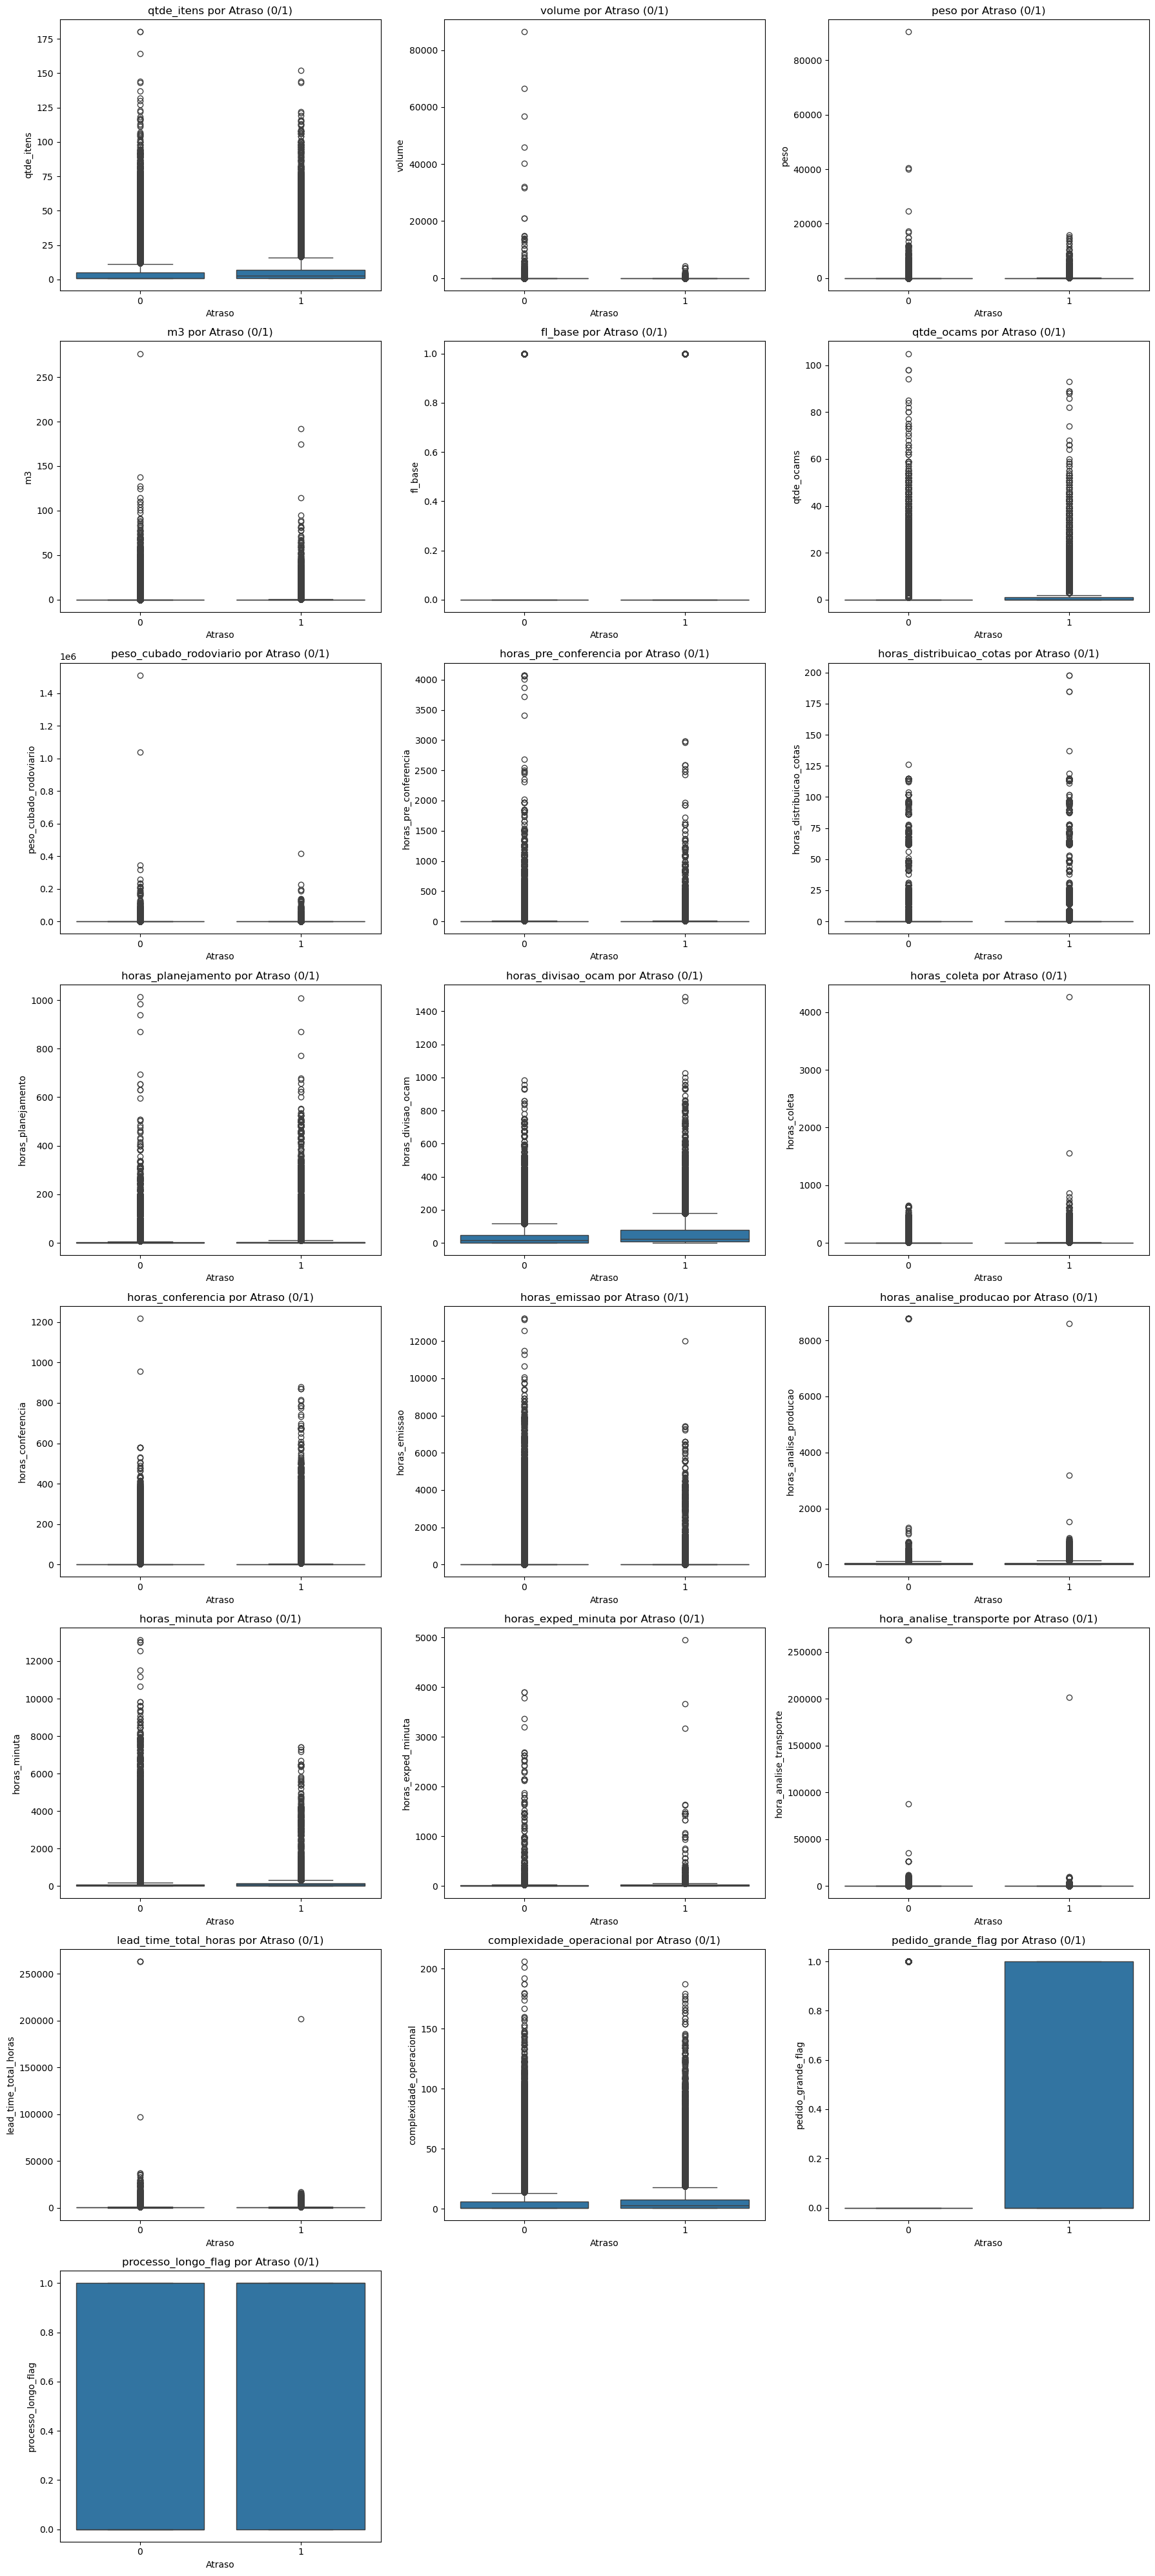

In [ ]:
# Seleciona variáveis numéricas
num_cols = df_main.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != TARGET]

n_cols = 3   # gráficos por linha
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(18, 5 * n_rows))

for idx, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, idx)
    sns.boxplot(x=df_main[TARGET], y=df_main[col])
    plt.title(f"{col} por Atraso (0/1)", fontsize=12)
    plt.xlabel("Atraso")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


# **Conclusões – Análise Inferencial (Correlação, ANOVA, Qui-Quadrado e Atraso x Não Atraso)**

Nesta etapa avaliamos a relação estatística entre as features operacionais e o atraso da entrega (`fl_atraso_cli`).
O objetivo foi identificar **quais variáveis realmente diferenciam** pedidos entregues no prazo e pedidos atrasados.

---

## **1. Correlações (Pearson e Spearman)**

### **Principais achados**

- **Pearson (linear)** mostrou correlações fracas (todas < 0.12), indicando que **relações lineares simples não explicam bem o atraso**.
- **Spearman (monotônica)** revelou correlações maiores, especialmente com:

  - `m3` (0.20)
  - `peso_cubado_rodoviario` (0.19)
  - `horas_minuta` (0.19)
  - `peso` (0.16)
  - `volume` (0.15)
  - `horas_coleta` (0.14)

Essas variáveis representam **complexidade física do pedido**, reforçando que **pedidos grandes têm maior risco de atraso**, mesmo sem relação linear simples.

---

## **2. ANOVA – Diferença de médias entre Atraso vs Não Atraso**

O teste ANOVA encontrou **diferenças de média altamente significativas (p < 0.0001)** em praticamente todas as variáveis numéricas analisadas.

### **Principais diferenciadores:**

- `horas_planejamento`
- `horas_divisao_ocam`
- `horas_conferencia`
- `horas_coleta`
- `m3`
- `peso`
- `qtde_itens`
- `horas_minuta`

Todas estas etapas têm **carga de trabalho muito maior nos pedidos atrasados**, sugerindo que **quanto maior a complexidade operacional → maior o esforço → maior a chance de atraso.**

Variáveis que *não* diferenciaram os grupos:

- `horas_distribuicao_cotas`
- `hora_analise_transporte`
- `volume` (limite, p ≈ 0.07)

---

## **3. Qui-Quadrado – Dependência entre variáveis categóricas e atraso**

Todas as variáveis categóricas relevantes mostraram **dependência estatística com o atraso** (p < 0.0001):

- `sigla_cliente`
- `tipo_veiculo`
- `uf`
- `modalidade`

Isso é extremamente importante, pois o **atraso não depende apenas de características internas do pedido, mas também do contexto operacional do cliente, região e do tipo de operação.**

A única variável menos relevante foi:

- `flag_entrega_agendada` (efeito pequeno apesar do p baixo)

---

## **4. Separabilidade – Diferenças práticas entre os grupos**

Ao comparar as médias entre atrasados e não atrasados, encontramos:

### **As maiores diferenças relativas (> 50%)**

- `horas_planejamento` (+131%)
- `horas_conferencia` (+96%)
- `horas_coleta` (+76%)
- `m3` (+64%)
- `peso` (+56%)
- `fl_base` (+55%)

Essas etapas DUPLICAM nos pedidos atrasados — **um padrão muito forte operacionalmente**, mesmo que o Cohen's d seja moderado (pois a variância é muito alta).

### **Novas features**

- `pedido_grande_flag` → praticamente todos os pedidos atrasados estão nesta classe
- `complexidade_operacional` → maior no grupo atrasado
- `lead_time_total_horas` → mais disperso, mas útil no modelo
- `processo_longo_flag` → aparece em ambos os grupos (não separa bem sozinho)

---

# **Conclusão Final**

A análise inferencial confirmou, com forte evidência estatística, que:

**1. O atraso é influenciado por múltiplos fatores simultâneos como:** complexidade física (peso, volume, m3, qtde_itens), granularidade operacional (qtde_ocams), etapas críticas (planejamento, conferência, coleta, minuta), características categóricas e(cliente, UF, tipo de veículo, modal).

**2. Não existe UMA causa clara, mas sim uma COMBINAÇÃO de fatores,** por isso o modelo de Machine Learning é necessário, pois ele capturará padrões não lineares entre variáveis.

**3. As variáveis identificadas como estatisticamente relevantes deverão entrar na modelagem.**

**4. A inferência reforça exatamente o que o time operacional suspeita que**, pedidos grandes, pesados, complexos e distribuídos entre vários galpões têm maior risco de atraso.

In [61]:
# Caminho do diretório processed
processed_path = "../database/processed"

# Nome do arquivo final
file_name = "acompanhamento_operacional_fe.csv"

# Caminho completo
full_path = f"{processed_path}/{file_name}"

# Salva o DataFrame com as features finais
df_main.to_csv(full_path, index=False, encoding="utf-8-sig")

print(f"Arquivo salvo com sucesso em: {full_path}")
print("Shape final:", df_main.shape)

Arquivo salvo com sucesso em: ../database/processed/acompanhamento_operacional_fe.csv
Shape final: (488398, 29)


---

<div align="left">
  <a href="#topo" title="Voltar ao início do README">⬆️ Topo</a>
</div>

---